In [1]:
#%matplotlib notebook
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Read SkySat data

In [32]:
import glob

# load images from folder and rpcs from TXT
seq_id = 'p'
input_dir = os.path.join('ba_experiments/skysat-tristereo-sample-morenci/',seq_id)

# read tiff images 
myimages = np.sort(glob.glob(input_dir+'/*.tif'))
myimages = myimages[:6]
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })
#vistools.display_gallery(mycrops)

# load RPC coefficients
os.chdir('../s2p/')
from s2plib import rpc_model
myrpcs2 = [rpc_model.RPCModel('../IS18/'+os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
print('Finished loading RPC coefficients')
os.chdir('../IS18/')

Found 6 images
Number of images to be used: 6
Finished loading RPC coefficients


In [33]:
# approximate rpcs as a as projective matrices
os.chdir('../IS18/')

os.chdir('../s2p/')
from s2plib import rpc_utils
cam_model = 'Perspective'
P_crop = []
cont = 0
for rpc2, crop in zip(myrpcs2, mycrops):
    print(cont)
    x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
    P_img = rpc_utils.approximate_rpc_as_projective(rpc2, [x,x+w,10], [y,y+h,10], \
                                                    [rpc2.altOff - 100, rpc2.altOff + 100, 10], verbose=False)
    P_crop.append(P_img/P_img[2,3])
    cont += 1
print('RPCs successfully approximated as projection matrices')
os.chdir('../IS18/')

0
1
2
3
4
5
RPCs successfully approximated as projection matrices


### Detect feature tracks

In [44]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2
from timeit import Timer

#FEATURE TRACKS REPRESENTATION
#feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
#r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'

def build_tracks(mycrops):

    print('Starting feature track detection...\n')

    # (1) detect SIFT keypoints
    features = []
    cont = 0
    reduce_kp = False
    max_kp_per_im = 7000  
    for f in range(len(mycrops)):
        kp, des = ba_utils.find_SIFT_kp(mycrops[f]['crop'])
        if len(kp) > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(len(kp))
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
            kp, des = new_kp, new_des
        features.append({ 'kp': kp, 'des': des })
        print('Found', len(kp), 'keypoints in image', cont)
        cont += 1
        #im_kp=cv2.drawKeypoints(mycrops[f]['crop'],kp,outImage=np.array([]))
        #vistools.display_image(im_kp)

    print('\n')

    # (2) create feature tracks
    tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
    for i in range(n_cam):
        kp_i, des_i = features[i]['kp'], features[i]['des']
        for j in range(i+1,n_cam):
            kp_j, des_j = features[j]['kp'], features[j]['des']
            pts_i, pts_j, kp_i, kp_j, m_filt, m_all = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
            n_matches = 0 if pts_i is None else pts_i.shape[0]
            print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))

            # display matches for pair (i,j)
            #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
            #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

            # if point i belongs to an existing track, then add point j... else, create new track
            for k in range(n_matches):
                xi, yi = pts_i[k,:]
                xj, yj = pts_j[k,:]
                list_of_existing_tracks_in_i = feature_tracks[:,:,i].tolist()           
                try:
                    existing_track_id = list_of_existing_tracks_in_i.index([xi, yi])
                    feature_tracks[existing_track_id,:,j] = [xj, yj]
                    r[existing_track_id,i], r[existing_track_id,j] = 1, 1
                except ValueError:
                    tracks_id += 1
                    new_track = np.zeros((1,2,n_cam))
                    new_track[:,:,i], new_track[:,:,j]  = [xi, yi], [xj, yj]
                    tmp = np.zeros((1,n_cam))
                    tmp[:,i], tmp[:,j] = 1, 1
                    feature_tracks, r = np.vstack((feature_tracks, new_track)), np.vstack((r, tmp))

    feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
    n_pts = feature_tracks.shape[0]
    print('\nFound', n_pts, 'feature tracks.\n')
    return feature_tracks, r

#timer = Timer(lambda: build_tracks(mycrops))
#elapsed_time = timer.timeit(number=1)
#hours, rem = divmod(elapsed_time, 3600)
#minutes, seconds = divmod(rem, 60)
#print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

feature_tracks, r = build_tracks(mycrops)

Starting feature track detection...

Found 28263 keypoints in image 0
Found 27949 keypoints in image 1
Found 28498 keypoints in image 2


Pair (0,1) -> 9226 matches preserved out of 28263


KeyboardInterrupt: 

### Detect feature tracks

In [34]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2
from timeit import Timer

#FEATURE TRACKS REPRESENTATION
#feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
#r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'

def build_tracks2(mycrops):

    print('Starting feature track detection...\n')

    # (1) detect SIFT keypoints
    features = []
    cont = 0
    reduce_kp = False
    max_kp_per_im = 7000  
    for f in range(len(mycrops)):
        kp, des = ba_utils.find_SIFT_kp(mycrops[f]['crop'])
        if len(kp) > max_kp_per_im and reduce_kp:
            prev_idx = np.arange(len(kp))
            new_idx = np.random.choice(prev_idx,max_kp_per_im,replace=False)
            new_kp, new_des = [kp[j] for j in new_idx], [des[j] for j in new_idx]
            kp, des = new_kp, new_des
        features.append({ 'kp': kp, 'des': des })
        print('Found', len(kp), 'keypoints in image', cont)
        cont += 1
        #im_kp=cv2.drawKeypoints(mycrops[f]['crop'],kp,outImage=np.array([]))
        #vistools.display_image(im_kp)

    print('\n')

    # (2) create feature tracks
    tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
    for i in range(n_cam):
        kp_i, des_i = features[i]['kp'], features[i]['des']
        for j in range(i+1,n_cam):
            kp_j, des_j = features[j]['kp'], features[j]['des']
            pts_i, pts_j, kp_i, kp_j, m_filt, m_all = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6)
            n_matches = 0 if pts_i is None else pts_i.shape[0]
            print('Pair ({},{}) -> {} matches preserved out of {}'.format(i,j,n_matches,len(m_all)))

            # display matches for pair (i,j)
            #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
            #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))
  
            pts_i_tuples = [tuple(pair) for pair in pts_i.tolist()]
            pts_i_dict = {pair:i for i, pair in enumerate(pts_i_tuples)}

            pts_i_track = [tuple(pair) for pair in feature_tracks[:,:,i].tolist()]
            pts_i_track_dict = {pair:i for i, pair in enumerate(pts_i_track)}
            
            intersect = np.array([[pts_i_dict[k], pts_i_track_dict[k]] for k in pts_i_dict.keys()&pts_i_track_dict.keys()])
            # attention: the meaning/interst of 'intersect' is not trivial
            # each value in 'idx_pts_i' is the index of an observation X from 'pts_i', while each corresponding
            # value in 'idx_existing_tracks' is the index of the track that contains the observation X 
            if intersect.shape[0] > 0:
                idx_pts_i, idx_existing_tracks = intersect[:,0], intersect[:,1]
                # extend existing tracks by adding the coords of observation X in image j from pts_j
                feature_tracks[idx_existing_tracks,:,j] = pts_j[idx_pts_i,:]
                r[idx_existing_tracks,i], r[idx_existing_tracks,j] = 1, 1
            
            # list of points in 'pts_i' that do not correspond to any previous feature track
            new_pts_from_i = list(set(pts_i_dict) - set(pts_i_track_dict))
            new_pts_from_j = [tuple(pts_j[pts_i_dict[k],:]) for k in new_pts_from_i]
            new_tracks = np.zeros((len(new_pts_from_i),2,n_cam))
            new_tracks[:,:,i], new_tracks[:,:,j]  = np.array(new_pts_from_i), np.array(new_pts_from_j)
            new_r = np.zeros((len(new_pts_from_i),n_cam))
            new_r[:,i], new_r[:,j] = 1, 1
            feature_tracks, r = np.vstack((feature_tracks, new_tracks)), np.vstack((r, new_r))
            
    feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
    n_pts = feature_tracks.shape[0]
    print('\nFound', n_pts, 'feature tracks.\n')
    return feature_tracks, r

#timer = Timer(lambda: build_tracks2(mycrops))
#elapsed_time = timer.timeit(number=1)
#hours, rem = divmod(elapsed_time, 3600)
#minutes, seconds = divmod(rem, 60)
#print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

feature_tracks, r = build_tracks2(mycrops)

Starting feature track detection...

Found 44181 keypoints in image 0
Found 39711 keypoints in image 1
Found 45947 keypoints in image 2
Found 36496 keypoints in image 3
Found 46340 keypoints in image 4
Found 32398 keypoints in image 5


Pair (0,1) -> 2615 matches preserved out of 44181
Pair (0,2) -> 3057 matches preserved out of 44181
Pair (0,3) -> 241 matches preserved out of 44181
Pair (0,4) -> 318 matches preserved out of 44181
Pair (0,5) -> 56 matches preserved out of 44181
Pair (1,2) -> 768 matches preserved out of 39711
Pair (1,3) -> 4093 matches preserved out of 39711
Pair (1,4) -> 113 matches preserved out of 39711
Pair (1,5) -> 556 matches preserved out of 39711
Pair (2,3) -> 2884 matches preserved out of 45947
Pair (2,4) -> 3425 matches preserved out of 45947
Pair (2,5) -> 868 matches preserved out of 45947
Pair (3,4) -> 284 matches preserved out of 36496
Pair (3,5) -> 2715 matches preserved out of 36496
Pair (4,5) -> 3238 matches preserved out of 46340

Found 18251 feature t

In [ ]:
import pickle

pickle_out = open("features_1fps.pickle","wb")
pickle.dump([feature_tracks, r], pickle_out)
pickle_out.close()
print('done')

### Import feature tracks

In [35]:
import pickle

#pickle_in = open("features_1fps.pickle","rb")
#feature_tracks, r = pickle.load(pickle_in)

C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks, r), 6)


# invert the coordinates of the feature tracks
#C2 = np.zeros(C.shape)
#C2[::2,:] = C[1::2,:]
#C2[1::2,:] = C[::2, :]
#C = C2.copy()


# remove uncomplete tracks
#C = C[:, ~(np.sum((C!=C).astype(int), 0)).astype(bool)]

#print('Found {} complete tracks'.format(C.shape[1]))

n_complete_tracks = np.sum(1*(~(np.sum((C!=C).astype(int), 0)).astype(bool)))
print('Found {} tracks, {} of them complete'.format(C.shape[1], n_complete_tracks))

Found 18251 tracks, 1 of them complete


In [ ]:
# Select a random subset of 1000 obs

#idx_to_preserve = np.random.choice(np.arange(C.shape[1]), (4000,), replace=False)
#C = C[:,idx_to_preserve]

#C.shape[1]

### Initialize 3D points

In [36]:
print('Initializing 3D points...')

pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

print('...done!\n')

print(pts_3d)

Initializing 3D points...
...done!

[[-1772937.37552609 -5045678.7726897   3467368.62891554]
 [-1771773.91551444 -5046305.42220756  3467077.51119906]
 [-1771703.77250997 -5046470.58435106  3467331.95896822]
 ...
 [-1771950.97265451 -5046133.86105059  3466904.78602449]
 [-1772072.62058652 -5046028.59958772  3466976.56412404]
 [-1772247.26275825 -5045946.69452198  3466945.33204557]]


### Define BA input parameters

In [37]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

print('Defining BA input parameters...')

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

print('...done!\n')

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{} cam_params_opt.shape:{}\n'.format(pts_3d.shape, cam_params.shape, cam_params_opt.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

Defining BA input parameters...
...done!

pts_2d.shape:(39836, 2)  pts_ind.shape:(39836,)  cam_ind.shape:(39836,)
pts_3d.shape:(18251, 3)  cam_params.shape:(6, 11) cam_params_opt.shape:(6, 3)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Run BA

Shape of matrix A: 79672x54771
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.1143e+04                                    1.25e+10    
       1             10         7.8901e+04      2.24e+03       1.59e+02       1.18e+10    
       2             11         7.7237e+04      1.66e+03       7.33e+01       1.14e+10    
       3             12         7.6108e+04      1.13e+03       2.26e+02       1.10e+10    
       4             13         7.4169e+04      1.94e+03       2.58e+02       1.03e+10    
       5             14         7.3645e+04      5.24e+02       2.68e+02       9.73e+09    
       6             15         7.2939e+04      7.06e+02       6.90e+01       9.54e+09    
       7             16         7.1847e+04      1.09e+03       1.43e+02       9.13e+09    
       8             17         7.0830e+04      1.02e+03       1.43e+02       8.18e+09    
       9             18         6.9416e+04      1.41e+03   

      89             103        1.0001e+04      7.12e+02       2.68e+02       8.71e+08    
      90             105        9.7944e+03      2.07e+02       1.35e+02       4.96e+08    
      91             106        9.6452e+03      1.49e+02       1.51e+02       6.82e+08    
      92             107        9.4760e+03      1.69e+02       1.30e+02       4.10e+08    
      93             108        9.4565e+03      1.95e+01       1.61e+02       5.10e+08    
      94             109        9.3972e+03      5.93e+01       3.31e+01       3.25e+08    
      95             110        9.3341e+03      6.31e+01       3.44e+01       4.18e+08    
      96             111        9.3273e+03      6.78e+00       6.60e+01       3.61e+08    
      97             112        9.2894e+03      3.80e+01       2.05e+01       2.96e+08    
      98             113        9.2774e+03      1.19e+01       4.11e+01       3.20e+08    
      99             114        9.2613e+03      1.61e+01       8.27e+00       1.15e+08    

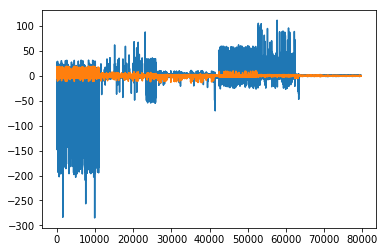

In [38]:
import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    n_p = ba_params['n_params']
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
    print(x0.shape)
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-10, loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
print(P_crop[0]/P_crop[0][-1,-1])
print(P_crop_ba[0])

In [ ]:
cam_params_ba

In [ ]:
#K, R, vecT, C = ba_utils.decompose_projection_matrix(P_crop_ba[0])

#print(R)

### Check BA error

Error before BA (mean / median): 4.55 / 0.97
Error after  BA (mean / median): 0.68 / 0.35


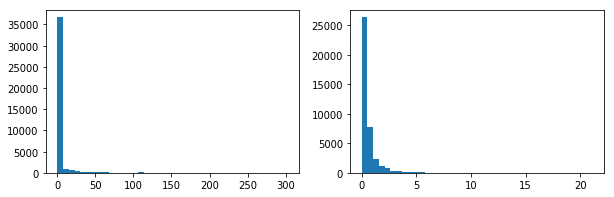

In [39]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)
#des_norm[des_norm == 0.0] = 1.0

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [ ]:
max(C[1,:])

 ----> Real 2D loc in im 1  (sol) =  [1814.173584  957.854492]
 ----> Proj 2D loc in im 1  before BA =  [1813.36250165  959.59170092]
 ----> Proj 2D loc in im 1  after  BA =  [1814.92152876  957.44893147]
 -----------> Reprojection error beofre BA: 2.5482912713749784
 -----------> Reprojection error after  BA: 1.1535052953905733
 ----> Real 2D loc in im 3  (sol) =  [1892.056152 1032.443481]
 ----> Proj 2D loc in im 3  before BA =  [1892.19238513 1031.34114526]
 ----> Proj 2D loc in im 3  after  BA =  [1891.88688181 1033.39493366]
 -----------> Reprojection error beofre BA: 1.2385688619751818
 -----------> Reprojection error after  BA: 1.1207228503801616
 ----> Real 2D loc in im 5  (sol) =  [1795.671265  965.405701]
 ----> Proj 2D loc in im 5  before BA =  [1795.74004534  967.12744096]
 ----> Proj 2D loc in im 5  after  BA =  [1795.39135644  965.1130255 ]
 -----------> Reprojection error beofre BA: 1.7905203034162014
 -----------> Reprojection error after  BA: 0.5725840665091937

3D coo

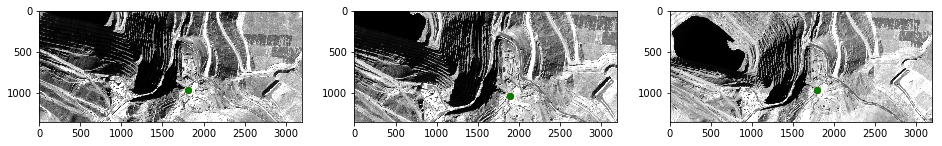

In [40]:
n_pts = C.shape[1]
#p_ind = pts_ind[np.argmax(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))] # idx of observation with max error
p_ind = np.random.choice(np.arange(0,n_pts))
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(16,12))
                                           
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),p_ind]
    
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    #reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2
    
    #if cont == 0:
        #print('3D location a. triangulation:', pts_3d[p_ind,:].ravel())
        #print('3D location a. bundle adjust:', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' before BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' after  BA = ', p_2d_proj_ba.ravel())
    print(' -----------> Reprojection error beofre BA:', np.sum(abs(p_2d_proj.ravel() - p_2d_gt)))
    print(' -----------> Reprojection error after  BA:', np.sum(abs(p_2d_proj_ba.ravel() - p_2d_gt)))
    #print(' ----> Proj 2D loc in im', i, ' a. BA = ', p_2d_proj_ba.ravel(), '\n')
    
    im = 255.*np.ones((1000,1000))
    #f[cont].imshow(im.squeeze(), cmap="gray", vmin=0, vmax=255)
    f[cont].imshow((mycrops[i]['crop']), cmap="gray")
    f[cont].plot(*p_2d_gt, "yo")
    f[cont].plot(*p_2d_proj, "ro")
    #f[cont].plot(*p_2d_gt[::-1], "yo")
    #f[cont].plot(*p_2d_proj[::-1], "ro")    
    f[cont].plot(*p_2d_proj_ba, "go")
    
#print('Reprojection error a. BA: ', reprojection_error_ba)

le_pt_3d = pts_3d_ba[p_ind,:]
print('\n3D coordinates:', le_pt_3d)

x , y, z = le_pt_3d[0], le_pt_3d[1], le_pt_3d[2]
lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
print('lat, lon: {:.3f}, {:.3f}, alt: {:.3f}'.format(lat, lon, h))

In [ ]:
# check the distance between the two projection rays for the 3d point p_ind

K, R, vecT, C1 = ba_utils.decompose_projection_matrix(P_crop_ba[i1])

dir_vec_ray1 = np.linalg.inv(K @ R) @ np.expand_dims(np.hstack((pt1, np.ones(1))), axis=1)

print(dir_vec_ray1)

K, R, vecT, C2 = ba_utils.decompose_projection_matrix(P_crop_ba[i2])

dir_vec_ray2 = np.linalg.inv(K @ R) @ np.expand_dims(np.hstack((pt2, np.ones(1))), axis=1)

print(dir_vec_ray2.shape)

# eq of ray 1 --> ray1 = C1 + t * dir_vec_ray1, where t is an scalar 
# eq of ray 2 --> ray2 = C2 + t * dir_vec_ray2, where t is an scalar

n = np.cross(dir_vec_ray1, dir_vec_ray2, axis=0)
d = np.dot((C2 - C1), n) / np.linalg.norm(n)

print('distance is {} m'.format(np.linalg.norm(d)))

In [42]:
from PIL import Image

#project the dsm of sift points and the triangulation error BEFORE BA


col = np.array([[255,   0, 0], [0,   255,   0], [0,   0,   255], [255, 255, 0], [255, 0, 255], [0, 255, 255], 
                [255, 155, 0], [155, 255,   0], [155, 0,   255], [255, 0, 155], [0, 255, 155], [0, 155, 255],
                [0,     0, 0], [255, 255, 255], [155, 155, 155]])

#_,f = plt.subplots(1, 2, figsize=(10,3))

folder = 'ba_experiments/exp_skysat/skysat-tristereo-sample-morenci/p/ALLim_incompleteT'


n_pts = C.shape[1]
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        '''
        pts_3d_tmp = np.zeros((n_pts,3))
        tr_err_tmp = np.zeros((n_pts,1))
        
        #current_pair = [0,5]
        #q,p = current_pair[0], current_pair[1]
        
        for i in range(n_pts):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop[q], P_crop[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)
            tr_err_tmp[i,0] = ba_utils.dist_between_proj_rays(pt1,pt2,P1,P2)

        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T

        ba_utils.write_point_cloud_ply(folder+'/{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])

        emin, emax, nmin, nmax = min(east), max(east), min(north), max(north)
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_dsm_{}_{}.tif'.format(q,p))
        xyz = np.vstack((east, north, tr_err_tmp.ravel())).T
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_tr_err_{}_{}.tif'.format(q,p))

        #f[0].hist(tr_err_tmp.ravel(), bins=40); 
        '''
        #project the dsm of sift points and the triangulation error AFTER BA
    
        pts_3d_tmp = np.zeros((n_pts,3))
        tr_err_tmp = np.zeros((n_pts,1))

        for i in range(C.shape[1]):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba[q], P_crop_ba[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)
            tr_err_tmp[i,0] = ba_utils.dist_between_proj_rays(pt1,pt2,P1,P2)

        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = ba_utils.ecef_to_latlon_custom(x, y, z)
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T

        ba_utils.write_point_cloud_ply(folder+'/ba/{:02}_{:02}_ba.ply'.format(q,p), xyz, color=col[cont,:])

        emin, emax, nmin, nmax = min(east), max(east), min(north), max(north)
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_dsm_{}_{}_ba.tif'.format(q,p))
        xyz = np.vstack((east, north, tr_err_tmp.ravel())).T
        dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=10.0)
        im = Image.fromarray(dem_nan.T)
        im.save(folder+'/sift_dsm/sift_tr_err_{}_{}_ba.tif'.format(q,p))

        #f[1].hist(tr_err_tmp.ravel(), bins=40); 
        print('done!')

LinAlgError: SVD did not converge

In [ ]:
dir_vec_ray1 = np.array([1,1,2])
dir_vec_ray2 = np.array([1,1,3])

C1 = np.array([0,2,-1])
C2 = np.array([1,0,-1])

n = np.cross(dir_vec_ray1, dir_vec_ray2)

d = np.dot((C2 - C1), n) / np.linalg.norm(n)

print('distance is {} m'.format(d))

In [ ]:
(float(3)/2) *np.sqrt(2)

In [ ]:
3* np.sqrt(133)

46.9899033525775
2992
mean abs reproj error in image 0 is 0.18430949233456043


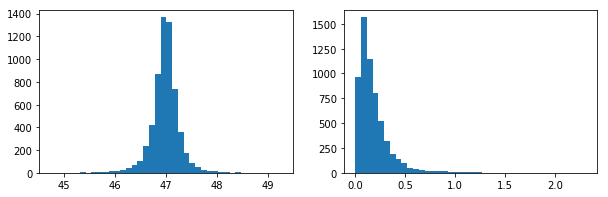

In [58]:
### visualize initial reprojection errors

mode = 'input'

if mode == 'input':
    err = np.add.reduceat(abs(f0), np.arange(0, len(f0), 2))
else:
    err = np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2))

thr = np.quantile(err, 0.5)
print(thr)

#thr = np.inf

in_e, ba_e = [], []


i = 0
pts_gt, pts_reproj = [], []
for j in range(C.shape[1]):
    if not np.isnan(C[i*2,j]):
        p_2d_proj = np.reshape(C[(i*2):(i*2+2),j], (2,1))
        proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[j,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1] 
        proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[j,:], np.ones(1))), axis=1)
        reproj_ba = proj[0:2,:] / proj[-1,-1]  
        abs_reproj_e = np.sum(abs(p_2d_proj - reproj))
        abs_reproj_e_ba = np.sum(abs(p_2d_proj - reproj_ba))
        
        in_e.append(abs_reproj_e)
        ba_e.append(abs_reproj_e_ba)
        
        if mode == 'input':
            tmp = abs_reproj_e
        else:
            tmp = abs_reproj_e_ba
        
        #print(abs_reproj_e)
        
        if tmp < thr:
            pts_gt.append(p_2d_proj)
            
            if mode == 'input':
                pts_reproj.append(reproj)
            else:
                pts_reproj.append(reproj_ba)
                
pts_gt, pts_reproj = np.array(pts_gt)[:,:,0], np.array(pts_reproj)[:,:,0]

print(pts_gt.shape[0])

print('mean abs reproj error in image {} is {}'.format(i, np.mean(ba_e))) 

# image 0
_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(in_e, bins=40); 
f[1].hist(ba_e, bins=40);

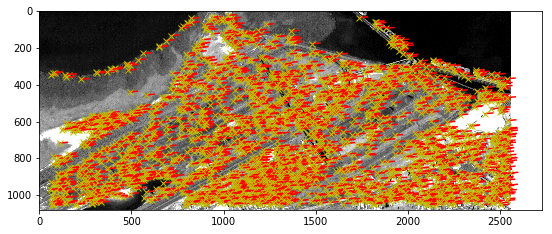

In [61]:
f = plt.figure(figsize=(9,9))
plt.imshow((mycrops[i]['crop']), cmap="gray")
for k in range(pts_gt.shape[0]):
    plt.plot([pts_gt[k,0], pts_reproj[k,0] ], [pts_gt[k,1], pts_reproj[k,1]], 'r-')
    plt.plot(*pts_gt[k], 'yx')
    
plt.show()

In [ ]:
#C = C[:,:500]
#pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)


col = np.array([[255, 0, 0],[0, 255, 0], [0, 0, 255]])
n_pts, n_cam = C.shape[1], int(C.shape[0]/2)
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop[q], P_crop[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        print(q,p)
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_v2__ba_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])
        
        _,f = plt.subplots(1, 2, figsize=(10,3))
        f[0].hist(h, bins=40); 
        f[1].hist(lon, bins=40);

In [ ]:
mymap = vistools.clickablemap(zoom=12)
display(mymap)

lat_min, lat_max, lon_min, lon_max = 118.576, 118.607, -20.329, -20.313


## set the coordinates of the area of interest as a GeoJSON polygon
# Buenos aires AOI
aoi_buenos_aires = {'coordinates': [[[lat_min, lon_min],
   [lat_min, lon_max],
   [lat_max, lon_max],
   [lat_max, lon_min],
   [lat_min, lon_min]]],
 'type': 'Polygon'}
# add center field
aoi_buenos_aires['center'] = np.mean(aoi_buenos_aires['coordinates'][0][:4], axis=0).tolist()

mymap.center = np.mean(aoi_buenos_aires['coordinates'][0][:4], axis=0).tolist()[::-1]

# add a polygon and center the map
mymap.add_GeoJSON(aoi_buenos_aires)  # this draws the polygon described by aoi
mymap.center = aoi_buenos_aires['center'][::-1]  # aoi_buenos_aires['coordinates'][0][0][::-1] 
mymap.zoom = 15

In [ ]:
mymap.center = [-20.329, 118.576]

In [ ]:
C.shape

In [ ]:
# Project X_ba with P_ba -> tracks_ba
# Run BA using X and P... and see if we are able to fit tracks_ba

C_ba = np.zeros(C.shape)
for i in range(C.shape[1]):
    for j in range(int(C.shape[0]/2)):
        proj = P_crop_ba[j] @ np.expand_dims(np.hstack((pts_3d_ba[i,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1]
        C_ba[2*j,   i] = reproj[0]
        C_ba[2*j+1, i] = reproj[1]

print('Initial 3D points:\n', pts_3d)

pts_3d_ba, C_ba = ba_utils.initialize_3d_points(P_crop, C_ba, cam_model, var_filt=False, var_hist=True)

'''
C_fake = np.zeros(C.shape)
for i in range(C.shape[1]):
    for j in range(int(C.shape[0]/2)):
        proj = P_crop[j] @ np.expand_dims(np.hstack((pts_3d[i,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1]
        C_fake[2*j,   i] = reproj[0]
        C_fake[2*j+1, i] = reproj[1]
'''
pts_3d_opt = pts_3d_ba.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C_ba, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    n_p = ba_params['n_params']
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-8, #loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d_opt, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba_2, cam_params_ba_2, P_crop_ba_2 = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)
#des_norm[des_norm == 0.0] = 1.0

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [ ]:
#C = C[:,:500]
#pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)

n_pts, n_cam = C.shape[1], int(C.shape[0]/2) 
for q in range(n_cam):
    for p in range(q+1, n_cam):
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C_ba[(q*2):(q*2+2),i], C_ba[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba_2[q], P_crop_ba_2[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_l1_back_to_init_{:02}_{:02}.ply'.format(q,p), xyz)

In [ ]:
K, _, _, _ = ba_utils.decompose_projection_matrix(P_crop[0])
print(K)

### Add noise

In [ ]:
P_crop_new = []
for i in range(len(P_crop)):
    K, R, vecT, c = ba_utils.decompose_projection_matrix(P_crop[i])
    K[0,0] *= 2
    K[1,1] *= 2
    P_crop_new.append(K @ R @ np.hstack((np.eye(3), -c[:, np.newaxis])))

In [ ]:
max(C[0,:])

In [ ]:
C_ba_noisy = C_ba + np.random.normal(0.0, 0.5, C_ba.shape)

C_ba_noisy[np.array([0,2,4]),:] -= 2560.0/2
C_ba_noisy[np.array([1,3,5]),:] -= 1080.0/2 
M_d = np.hypot(C_ba_noisy[np.array([0,2,4]),:], C_ba_noisy[np.array([1,3,5]),:]) 
M_d = np.repeat(M_d, 2, axis=0)
k1 = 0.0001
C_ba_noisy *= (1 + (k1* M_d)**2)
C_ba_noisy[np.array([0,2,4]),:] += 2560.0/2
C_ba_noisy[np.array([1,3,5]),:] += 1080.0/2 

# Run BA using X and P... and see if we are able to fit tracks_ba (noisy)

print('Initial 3D points:\n', pts_3d)

pts_3d, C_ba_noisy = ba_utils.initialize_3d_points(P_crop_new, C_ba_noisy, cam_model, var_filt=False, var_hist=True)

print('Initial 3D points:\n', pts_3d)

pts_3d_opt = pts_3d.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop_new, C_ba_noisy, cam_model, R_params='Euler', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

import time
from scipy.optimize import least_squares, minimize

pts_2d_w = np.ones(pts_2d.shape[0])

# compute loss value and plot residuals at the initial parameters
if ba_params['opt_K'] and ba_params['fix_K']:
    n_p = ba_params['n_params']
    params_in_K = 3 if cam_model == 'Affine' else 5
    K = cam_params_opt[0,-params_in_K:]
    cam_params_opt2 = np.hstack([cam_params_opt[cam_id, :-params_in_K] for cam_id in range(n_cam)])
    cam_params_opt2 = np.hstack((K, cam_params_opt2))
    x0 = np.hstack((cam_params_opt2.ravel(), pts_3d_opt.ravel()))
else:
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
    
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, xtol=1e-8, #loss='soft_l1', f_scale = 0.5,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params, pts_2d_w))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba_3, cam_params_ba_3, P_crop_ba_3 = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

In [ ]:
#C = C[:,:500]
#pts_3d, C = ba_utils.initialize_3d_points(P_crop, C, cam_model, var_filt=False, var_hist=True)


col = np.array([[255, 0, 0],[0, 255, 0], [0, 0, 255]])
n_pts, n_cam = C.shape[1], int(C.shape[0]/2)
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C_ba_noisy[(q*2):(q*2+2),i], C_ba_noisy[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba_3[q], P_crop_ba_3[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_synth_ba_noisy_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])

In [ ]:
# check BA error performance

des_norm = np.repeat(pts_2d_w,2, axis=0)
#des_norm[des_norm == 0.0] = 1.0

init_e = np.sort(np.add.reduceat(abs(f0.astype(float)/des_norm), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun.astype(float)/des_norm), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

In [ ]:
### visualize initial reprojection errors

mode = 'output'

if mode == 'input':
    err = np.add.reduceat(abs(f0), np.arange(0, len(f0), 2))
else:
    err = np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2))

thr = np.quantile(err, 0.5)
print(thr)

thr = np.inf

in_e, ba_e = [], []


i = 2
pts_gt, pts_reproj = [], []
for j in range(C.shape[1]):
    if not np.isnan(C[i*2,j]):
        p_2d_proj = np.reshape(C_ba_noisy[(i*2):(i*2+2),j], (2,1))
        proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[j,:], np.ones(1))), axis=1)
        reproj = proj[0:2,:] / proj[-1,-1] 
        proj = P_crop_ba_3[i] @ np.expand_dims(np.hstack((pts_3d_ba_3[j,:], np.ones(1))), axis=1)
        reproj_ba = proj[0:2,:] / proj[-1,-1]  
        abs_reproj_e = np.sum(abs(p_2d_proj - reproj))
        abs_reproj_e_ba = np.sum(abs(p_2d_proj - reproj_ba))
        
        in_e.append(abs_reproj_e)
        ba_e.append(abs_reproj_e_ba)
        
        if mode == 'input':
            tmp = abs_reproj_e
        else:
            tmp = abs_reproj_e_ba
        
        #print(abs_reproj_e)
        
        if tmp < thr:
            pts_gt.append(p_2d_proj)
            
            if mode == 'input':
                pts_reproj.append(reproj)
            else:
                pts_reproj.append(reproj_ba)
                
pts_gt, pts_reproj = np.array(pts_gt)[:,:,0], np.array(pts_reproj)[:,:,0]

print(pts_gt.shape[0])

print('mean abs reproj error in image {} is {}'.format(i, np.mean(ba_e))) 

# image 0
_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(in_e, bins=40); 
f[1].hist(ba_e, bins=40);

In [ ]:
cam_idx = 2
print(cam_params[cam_idx,-5:])
print(cam_params_ba_3[cam_idx,-5:])
print(np.allclose(cam_params[cam_idx,:],cam_params_ba_3[cam_idx,:]))

cam_idx = 1
print(cam_params[cam_idx,-5:])
print(cam_params_ba_3[cam_idx,-5:])
print(np.allclose(cam_params[cam_idx,:],cam_params_ba_3[cam_idx,:]))

cam_idx = 0
print(cam_params[cam_idx,-5:])
print(cam_params_ba_3[cam_idx,-5:])

print(np.allclose(cam_params[0,-5:],cam_params[1,-5:], cam_params[2,-5:]))

In [ ]:
lat_google, lon_google, alt_google = 53.539628, 9.935470, 10
x, y, z = ba_utils.latlon_to_ecef_custom(lat_google, lon_google, alt_google)
ref_pt_3d_google = np.array([x,y,z])

east_sat, north_sat, alt_sat = 545609, 5.94523e+06, 854.433
lon_sat, lat_sat = utils.lonlat_from_utm(east_sat, north_sat, utils.zonestring_from_lonlat(lon_google, lat_google))
x, y, z = ba_utils.latlon_to_ecef_custom(lat_sat, lon_sat, alt_sat)
ref_pt_3d_sat = np.array([x,y,z])

_, _, _, C_cam1 = ba_utils.decompose_projection_matrix(P_crop_ba[1])
_, _, _, C_cam2 = ba_utils.decompose_projection_matrix(P_crop_ba[2])

vec_1 = C_cam1 - ref_pt_3d_sat
vec_2 = C_cam1 - ref_pt_3d_google

#normalize vectors
vec_1 /= np.linalg.norm(vec_1)
vec_2 /= np.linalg.norm(vec_2)

a = vec_1.ravel()
b = vec_2.ravel()

v = np.cross(a,b)
s = np.linalg.norm(v) 
c = np.dot(a, b) 
vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]]) 

#rot_tmp = np.eye(3) + ssc(cross_v) + (ssc(cross_v)* ((1-np.dot(A,B))/(np.linalg.norm(cross_v) ** 2))
R_google = np.eye(3) + vx + np.dot(vx,vx) * (1-c)/(s**2)

print(R_google)

In [ ]:
print(vec_2)
print(R_google @ vec_1)

In [ ]:
tmp = R_google @ ref_pt_3d_sat
tmp = ba_utils.ecef_to_latlon_custom(tmp[0], tmp[1], tmp[2])
print(tmp)

In [ ]:
P_crop_ba_2 = []
for i in range(n_cam):
    K, R, T, Ccam = ba_utils.decompose_projection_matrix(P_crop_ba[i])
    #newR = np.linalg.inv(R_google) @ R
    Prec = K @ R @ np.hstack((np.eye(3), - Ccam[:, np.newaxis]))
    P_crop_ba_2.append( R_google @ Prec)
    



col = np.array([[255, 0, 0],[0, 255, 0], [0, 0, 255]])
n_pts, n_cam = C.shape[1], int(C.shape[0]/2)
cont = -1
for q in range(n_cam):
    for p in range(q+1, n_cam):
        cont += 1
        pts_3d_tmp = np.zeros((n_pts,3))
        for i in range(n_pts):
            pt1, pt2 = C[(q*2):(q*2+2),i], C[(p*2):(p*2+2),i]
            P1, P2 = P_crop_ba_2[q], P_crop_ba_2[p]
            pts_3d_tmp[i,:] = ba_utils.linear_triangulation_single_pt(pt1,pt2,P1,P2)


        print('Initial 3D points:\n', pts_3d_tmp)

        # compare points in (lat, lon, alt) and (east, north) before and after BA
        os.chdir('../s2p/')
        from s2plib import geographiclib
        os.chdir('../IS18/')

        print('Before BA:')#354449.320, 6182457.920 - 10000000
        os.chdir('../s2p/')
        x , y, z = pts_3d_tmp[:,0], pts_3d_tmp[:,1], pts_3d_tmp[:,2]
        lat, lon, h = geographiclib.geocentric_to_geodetic(x, y, z)
        os.chdir('../IS18/')
        print('x: {:.3f}, {:.3f},    y: {:.3f}, {:.3f},     z: {:.3f}, {:.3f}' \
              .format(min(x), max(x), min(y), max(y), min(z), max(z)))
        print('lat: {:.3f}, {:.3f},    lon: {:.3f}, {:.3f},     alt: {:.3f}, {:.3f}' \
              .format(min(lat), max(lat), min(lon), max(lon), min(h), max(h)))
        
        print(q,p)
        
        east, north = utils.utm_from_lonlat(lon, lat)
        xyz = np.vstack((east, north, h)).T
        ba_utils.write_point_cloud_ply('3s_last_{:02}_{:02}.ply'.format(q,p), xyz, color=col[cont,:])
        
        _,f = plt.subplots(1, 2, figsize=(10,3))
        f[0].hist(lat, range=(53.5, 53.6), bins=40); 
        f[1].hist(lon, range=(9.9, 10.0), bins=40);
        
        _,f2 = plt.subplots(1, 2, figsize=(10,3))
        f2[0].hist(lat, bins=40); 
        f2[1].hist(lon, bins=40);        
        
        break
    break